<a href="https://colab.research.google.com/github/JonHaz/Ethereum/blob/main/Craft_a_Story_from_a_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's look at Ethereum Blck Data for the month of January

In [2]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [3]:
# Save output in a variable `df`

%%bigquery --project storied-sound-253213 df
SELECT
   timestamp, number, miner, difficulty, size, transaction_count, gas_limit, gas_used
FROM `bigquery-public-data.crypto_ethereum.blocks` 
WHERE DATE(timestamp) BETWEEN "2021-01-21" AND "2021-01-31"

In [4]:
df.head()

,timestamp,number,miner,difficulty,size,transaction_count,gas_limit,gas_used
0,2021-01-26 18:40:51+00:00,11733046,0xe9b54a47e3f401d37798fc4e22f14b78475c2afc,4555677847969696,30631,131,12463358,12312519
1,2021-01-26 19:00:37+00:00,11733125,0xe9b54a47e3f401d37798fc4e22f14b78475c2afc,4535597732214329,36646,137,12487720,12471475
2,2021-01-26 20:24:01+00:00,11733495,0xe9b54a47e3f401d37798fc4e22f14b78475c2afc,4539628804709390,54477,228,12506007,12465657
3,2021-01-26 07:43:29+00:00,11730032,0xe9b54a47e3f401d37798fc4e22f14b78475c2afc,4347916424230509,36333,111,12487794,12486637
4,2021-01-26 18:22:20+00:00,11732966,0xe9b54a47e3f401d37798fc4e22f14b78475c2afc,4564645896202664,37055,100,12457262,12450206


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71465 entries, 0 to 71464
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   timestamp          71465 non-null  datetime64[ns, UTC]
 1   number             71465 non-null  int64              
 2   miner              71465 non-null  object             
 3   difficulty         71465 non-null  object             
 4   size               71465 non-null  int64              
 5   transaction_count  71465 non-null  int64              
 6   gas_limit          71465 non-null  int64              
 7   gas_used           71465 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(5), object(2)
memory usage: 4.4+ MB


First let's analyze the columns 'size' and 'transaction_count'

In [6]:
df[['size','transaction_count']].describe()

,size,transaction_count
count,71465.000000,71465.000000
mean,44250.298174,183.449157
std,11875.228608,63.321700
min,518.000000,0.000000
25%,38987.000000,148.000000
50%,44818.000000,181.000000
75%,50330.000000,215.000000
max,205974.000000,595.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5abcb3d8d0>,
      dtype=object)

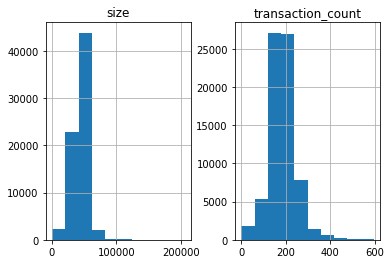

In [7]:
df[['size','transaction_count']].hist()

In [8]:
df[['size','transaction_count']].corr()

,size,transaction_count
size,1.000000,0.588667
transaction_count,0.588667,1.000000


How many miners do we have during this period?

In [9]:
df['miner'].groupby(df['miner']).count().sort_values(ascending=False).count()

91

The top 10% of Miners make up 82% of the the blocks during this month

```
# This is formatted as code
```



In [10]:
blocks = df['miner'].groupby(df['miner']).count().sort_values(ascending=False)

top_9 = blocks.nlargest(9)
top_9.sum()

top_9.sum()/blocks.sum()

0.8242076540964108

In terms of number of blocks what does that distribution look like?

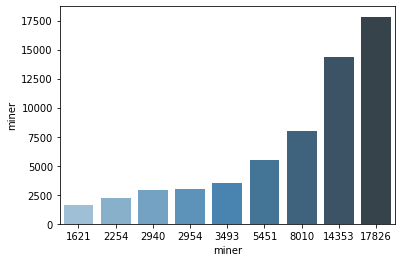

In [11]:

import seaborn as sns
import matplotlib.pyplot as plt

x=top_9.index
y = top_9

sns.barplot(x=x, y=y, data=blocks,
            label="Total", palette="Blues_d")

What percentage of blocks don't go through because the gas limit was too low

In [26]:
gas = df.loc[:,['miner','gas_limit','gas_used']]

#gas.count(gas['gas_limit'] == gas['gas_used'])
gas['gas_left'] = (gas['gas_limit'] - gas['gas_used'])
gas.head()

,miner,gas_limit,gas_used,gas_left
0,0xe9b54a47e3f401d37798fc4e22f14b78475c2afc,12463358,12312519,150839
1,0xe9b54a47e3f401d37798fc4e22f14b78475c2afc,12487720,12471475,16245
2,0xe9b54a47e3f401d37798fc4e22f14b78475c2afc,12506007,12465657,40350
3,0xe9b54a47e3f401d37798fc4e22f14b78475c2afc,12487794,12486637,1157
4,0xe9b54a47e3f401d37798fc4e22f14b78475c2afc,12457262,12450206,7056


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5ab7a0a250>,
      dtype=object)

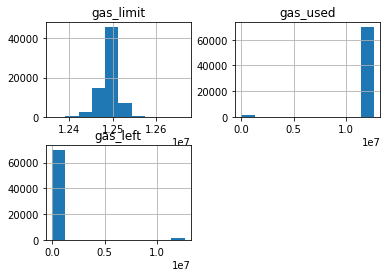

In [27]:
gas.hist()

In [29]:
#There are a lot of blocks that don't use any gas
gas.sort_values(by='gas_used', ascending=True)
gas[gas['gas_used']==0].count()

miner        1441
gas_limit    1441
gas_used     1441
gas_left     1441
dtype: int64

How much ETH was awareded to the top 9 miners?

In [33]:
# add the top 9 miners to a list
miners = list(top_9.index)
miners

['0x5a0b54d5dc17e0aadc383d2db43b0a0d3e029c4c',
 '0xea674fdde714fd979de3edf0f56aa9716b898ec8',
 '0x829bd824b016326a401d083b33d092293333a830',
 '0x04668ec2f57cc15c381b461b9fedab5d451c8f7f',
 '0x52bc44d5378309ee2abf1539bf71de1b7d7be3b5',
 '0xb3b7874f13387d44a3398d298b075b7a3505d8d4',
 '0x1ad91ee08f21be3de0ba2ba6918e714da6b45836',
 '0xd224ca0c819e8e97ba0136b3b95ceff503b79f53',
 '0x3ecef08d0e2dad803847e052249bb4f8bff2d5bb']

In [54]:
#creating a new column to calculate ethereum awarded 
gas['eth_awarded'] = gas['gas_used'] * 200 * 0.000000001

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 0x04668ec2f57cc15c381b461b9fedab5d451c8f7f to 0xea674fdde714fd979de3edf0f56aa9716b898ec8
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   eth_awarded  9 non-null      float64
 1   miner        9 non-null      object 
dtypes: float64(1), object(1)
memory usage: 216.0+ bytes


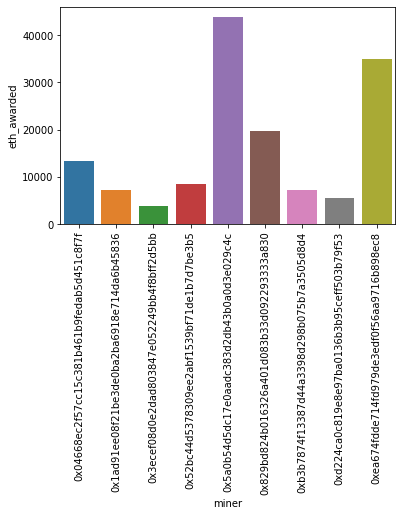

In [66]:
#filtering by top 9 miners
top_gas =gas[gas['miner'].isin(miners)]

#creating series to display revenues for top miners
top_eth = top_gas[['miner','eth_awarded']].groupby(top_gas['miner']).sum()
top_eth['miner'] = top_eth.index
top_eth.info()
plt.xticks(rotation=90)
sns.barplot(x='miner',y="eth_awarded", data=top_eth)

,miner,gas_limit,gas_used,gas_left,eth_awared,eth_awarded
0,0xe9b54a47e3f401d37798fc4e22f14b78475c2afc,12463358,12312519,150839,2.462504,2.462504
1,0xe9b54a47e3f401d37798fc4e22f14b78475c2afc,12487720,12471475,16245,2.494295,2.494295
2,0xe9b54a47e3f401d37798fc4e22f14b78475c2afc,12506007,12465657,40350,2.493131,2.493131
3,0xe9b54a47e3f401d37798fc4e22f14b78475c2afc,12487794,12486637,1157,2.497327,2.497327
4,0xe9b54a47e3f401d37798fc4e22f14b78475c2afc,12457262,12450206,7056,2.490041,2.490041
